In [1]:
%matplotlib inline
from catboost import CatBoostClassifier
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from imblearn.over_sampling import SMOTENC
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, VotingClassifier
from sklearn.metrics import roc_curve, confusion_matrix, f1_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import FeatureUnion, Pipeline
from sklearn.preprocessing import FunctionTransformer, LabelEncoder, OrdinalEncoder, OneHotEncoder, LabelBinarizer
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_graphviz
from sklearn.utils.multiclass import unique_labels

from source import add_mutationless_patients, load_avenio_files
from transform import categorical_columns_to_lower, ClassifierAsTransformer, clean_mutation_columns, dummy_encode_mutations, get_top_correlated, mutation_train_test_split, patient_allele_frequencies, get_top_genes
from views import plot_confusion_matrix

RANDOM_STATE = 1234
np.random.seed(RANDOM_STATE)

In [2]:
# Load data from spreadsheet and SPSS files.
mutation_data_frame, no_mutation_found_patients, phenotypes = load_avenio_files()

In [3]:
# Vocabulary is the entire dataset, not only training set. Otherwise we run into problems during inference.
gene_vocabulary = mutation_data_frame['Gene'].unique()
# allele_columns = ["T0: Allele \nFraction", "T1: Allele Fraction"]
allele_columns = ["T0: No. Mutant \nMolecules per mL", "T1: No. Mutant \nMolecules per mL"]

# raise Exception('Check allele columns!')

# Convert particular columns to numbers and drop rows with missing data.
mutation_data_frame = clean_mutation_columns(mutation_data_frame)

In [4]:
def f_t(t_0, t_1):
    return (t_1 - t_0) / t_0

In [5]:
def delta_t(t_0, t_1):
    return t_1 - t_0

In [6]:
patient_mutation_frequencies = patient_allele_frequencies(mutation_data_frame, gene_vocabulary, f_t)

Add zeros to the table for patients which have no mutations.

In [7]:
patient_mutation_frequencies = add_mutationless_patients(patient_mutation_frequencies, no_mutation_found_patients)

In [8]:
# Phenotype features that serve as input for the model.
phenotype_features = [
    "gender",
    "leeftijd",
    "stage",
    "therapyline",
    "smokingstatus",
    "Systemischetherapie",
    "histology_grouped",
    "lymfmeta",
    "brainmeta",
    "adrenalmeta",
    "livermeta",
    "lungmeta",
    "skeletonmeta",
]

# Phenotype labels that we wish to predict.
phenotype_labels = [
    # Labels:
    "Clinical_Response",
    "response_grouped",
    "progressie",
]
# The columns to extract from the SPSS file.
phenotypes_to_keep = phenotype_features + phenotype_labels

# From those listed above, the following columns are categorical (not counting the labels).
categorical_input_columns = [
    "gender",
    "stage",
    "therapyline",
    "smokingstatus",
    "Systemischetherapie",
    "histology_grouped",
    "lymfmeta",
    "brainmeta",
    "adrenalmeta",
    "livermeta",
    "lungmeta",
    "skeletonmeta",
]

# Combine mutation data and phenotype data.
X = pd.merge(
    left=patient_mutation_frequencies,
    right=phenotypes[phenotypes_to_keep],
    left_index=True,
    right_index=True,
)
X = categorical_columns_to_lower(X)
X.to_csv('combined_data.tsv', sep='\t')

In [9]:
X.dropna(subset=['response_grouped'], inplace=True)

# Extract the labels for the classifier.
y_resp = X.pop('Clinical_Response')
y_resp_gp = X.pop('response_grouped')
y_prog = X.pop('progressie')

Train-test split

In [10]:
f_test = 0.3
X_train, X_test, y_train, y_test = train_test_split(X, y_resp_gp, test_size=f_test, random_state=RANDOM_STATE)

In [11]:
y_train.value_counts()

non responder (sd+pd)    63
responder (pr+cr)        24
Name: response_grouped, dtype: int64

## Transformation pipeline
Turn categorical data to integers.

In [12]:
preprocess = ColumnTransformer([
#     ("LabelEncoder", OrdinalEncoder(), categorical_input_columns),
    ("LabelEncoder", OneHotEncoder(handle_unknown='ignore'), categorical_input_columns),
    ],
    remainder='passthrough',
)

Classification algorithms:

In [13]:
# tree_classifier = DecisionTreeClassifier(random_state=RANDOM_STATE, max_depth=3, class_weight='balanced')
# forest_classifier = RandomForestClassifier(random_state=RANDOM_STATE, n_estimators=50, max_depth=3, class_weight='balanced')
# gb_classifier = GradientBoostingClassifier(random_state=RANDOM_STATE, n_estimators=50)

Build entire processing pipeline, including a function to single out specific columns.

In [14]:
classifier_names = ['tree', 'forest', 'gradient boost', 'knn', 'catboost']

In [15]:
def generate_feature_names(categorical_column_names, column_names):
    """
    Re-order column names to match the pipeline transformation.
    """ 
    # `ColumnTransformer` moves all the categorical data to the front of the matrix.
    new_column_order = categorical_column_names.copy()
    # Concatenate the columns that are left untouched.
    for column in column_names:
        if column not in categorical_column_names:
            new_column_order.append(column)
    return new_column_order

In [16]:
def compare_pipelines(pipelines, oversample=False):
    if oversample:
            # Use synthetic minority oversampling technique for nominal and continuous data.
            categorical_feature_indices = [X_train.columns.get_loc(column) for column in categorical_input_columns]
            smote_nc = SMOTENC(categorical_features=categorical_feature_indices, random_state=RANDOM_STATE)
            X_resample, y_resample = smote_nc.fit_resample(X_train, y_train)
            X = pd.DataFrame(X_resample, columns=X_train.columns)
            y = pd.Series(y_resample)
    else:
        X, y = X_train, y_train
        
    pipeline_scores = []
    for p in pipelines:
        # Fit to (resampled) training data.
        p.fit(X, y)
        y_train_pred = p.predict(X_train)
        y_test_pred = p.predict(X_test)
        f1_train = f1_score(y_train, y_train_pred, pos_label='responder (pr+cr)')
        f1_test = f1_score(y_test, y_test_pred, pos_label='responder (pr+cr)')
        # Calculate scores for original training data and test set.
        pipeline_scores.append([p.score(X_train, y_train), f1_train, p.score(X_test, y_test), f1_test])
    return pd.DataFrame(pipeline_scores, columns=['train acc.', 'train F_1', 'test acc.', 'test F_1'])

In [17]:
def select_frequent_mutation_columns(X):
    """
    Select mutations that occur above a certain thresshold.
    """
    # Single out selected columns.
    return X[get_top_genes(patient_mutation_frequencies)]

In [18]:
def select_phenotype_columns(X):
    """
    Ignore mutaton data.
    """ 
    return X[phenotype_features]

In [19]:
def test_pipeline(p):
    p.fit(X_train, y_train)
    # Calculate training and testing scores.
    print(p.score(X_train, y_train), p.score(X_test, y_test))

In [20]:
def test_synthetic_pipeline(p):
    """
    Train pipeline on oversampled training data.
    """
    categorical_feature_indices = [X_train.columns.get_loc(column) for column in categorical_input_columns]
    # Use synthetic minority oversampling technique for nominal and continuous data (SMOTENC).
    smote_nc = SMOTENC(categorical_features=categorical_feature_indices, random_state=RANDOM_STATE)
    X_resample, y_resample = smote_nc.fit_resample(X_train, y_train)
    X_resample = pd.DataFrame(X_resample, columns=X_train.columns)
    y_resample = pd.Series(y_resample)
    print(y_resample.value_counts())
    p.fit(X_resample, y_resample)
    print(p.score(X_train, y_train), p.score(X_test, y_test))

In [21]:
get_top_genes(patient_mutation_frequencies)

array(['TP53', 'KRAS', 'CDKN2A', 'BRAF', 'NFE2L2', 'PIK3CA'], dtype=object)

In [22]:
def democratic_model(Classifier, **kwargs):
    """
    Democratic voting model where each model receives part of the data.
    """
    # Phenotype pipeline.
    phenotype_pipeline = Pipeline(steps=[
        ("select_columns", FunctionTransformer(select_phenotype_columns, validate=False)),
        ("transform_columns", preprocess), 
        ("classify", Classifier(**kwargs)),
    ])
    # Mutation pipeline.
    mutation_pipeline = Pipeline(steps=[
        ("select_columns", FunctionTransformer(select_frequent_mutation_columns, validate=False)),
        ("classify", Classifier(**kwargs)),
    ])
    # Pipeline with all
    all_pipeline = Pipeline(steps=[
        ("transform_columns", preprocess), 
        ('classify', Classifier(**kwargs)),
    ])
    
    v = VotingClassifier(
        estimators=[
            ('phenotype', phenotype_pipeline),
            ('mutation', mutation_pipeline),
            ('all', all_pipeline),
        ],
        voting='soft',
        # Model using all the data is given less weight.
#         weights=[2, 2, 1],
    )
    
    return v

In [23]:
def build_pipelines():
    classifiers = {
        DecisionTreeClassifier: {'random_state':RANDOM_STATE, 'max_depth': 5, 'class_weight': 'balanced'},
        RandomForestClassifier: {'random_state':RANDOM_STATE, 'n_estimators': 15, 'max_depth': 5, 'class_weight': 'balanced_subsample'},
        GradientBoostingClassifier: {'random_state':RANDOM_STATE, 'n_estimators': 15},
        KNeighborsClassifier: {'n_neighbors': 2, 'weights': 'distance'},
    }
    return [democratic_model(Classifier, **kwargs) for Classifier, kwargs in classifiers.items()]

In [24]:
v = democratic_model(DecisionTreeClassifier, max_depth=4)

In [25]:
v.fit(X_train, y_train)
v.score(X_train, y_train)
# v.estimators[0][1].predict(X_test)

0.8850574712643678

In [26]:
test_pipeline(v)

0.8850574712643678 0.7105263157894737


In [27]:
test_synthetic_pipeline(v)

responder (pr+cr)        63
non responder (sd+pd)    63
dtype: int64
0.8390804597701149 0.7105263157894737


In [28]:
classifiers = build_pipelines()

## Compare classifier with and without oversampling of minority class.

In [29]:
# Classifier without oversampling of minority class.
compare_pipelines(classifiers)

,train acc.,train F_1,test acc.,test F_1
0,0.919540,0.872727,0.736842,0.500000
1,0.942529,0.905660,0.605263,0.210526
2,0.793103,0.400000,0.789474,0.200000
3,1.000000,1.000000,0.710526,0.352941


In [30]:
# # Classifier with oversampling.
# compare_pipelines(classifiers, oversample=True)

## Plot confusion matrix

In [31]:
def plot_roc(model):
    y_pred = model.predict(X_test)
    # Transform to binary number.
    l = LabelBinarizer()
    l.fit(y_pred)
    non_responder_label = np.argwhere(l.classes_ == 'non responder (sd+pd)')[0,0]
    fpr, tpr, _ = roc_curve(l.transform(y_test), l.transform(y_pred), pos_label=non_responder_label)
    plt.plot(fpr, tpr)

$M_{ij}$: known to be in group $i$ but predicted to be in group $j$.

Confusion matrix, without normalization
[[23  6]
 [ 4  5]]


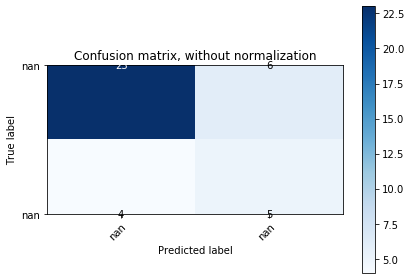

In [32]:
plot_confusion_matrix(y_test, classifiers[0].predict(X_test), y_test)

Confusion matrix, without normalization
[[21  8]
 [ 7  2]]


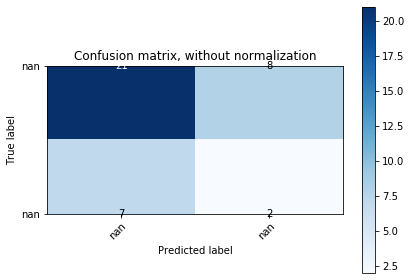

In [33]:
plot_confusion_matrix(y_test, classifiers[1].predict(X_test), y_test)

Confusion matrix, without normalization
[[29  0]
 [ 8  1]]


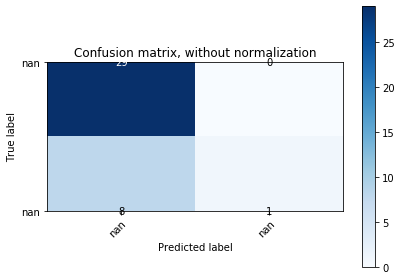

In [34]:
plot_confusion_matrix(y_test, classifiers[2].predict(X_test), y_test)

Confusion matrix, without normalization
[[24  5]
 [ 6  3]]


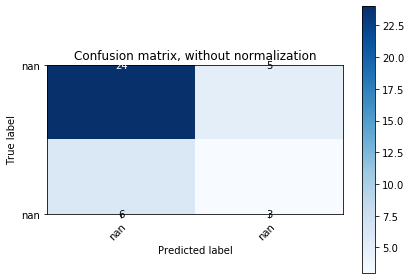

In [35]:
plot_confusion_matrix(y_test, classifiers[3].predict(X_test), y_test)

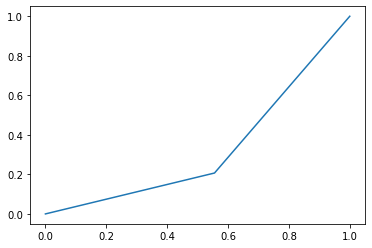

In [36]:
plot_roc(classifiers[0])

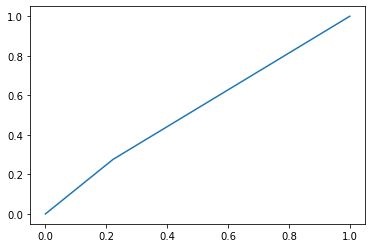

In [37]:
plot_roc(classifiers[1])

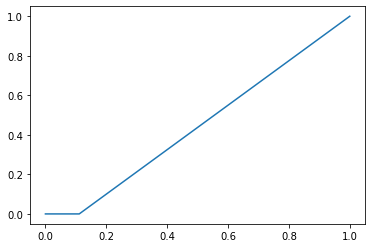

In [38]:
plot_roc(classifiers[2])